### Objectives
- The objective of this notebook is to start with modelling the data with Random Forest 
- Explain Random Forest 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os


from sklearn import preprocessing
import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
import os
from pandas_summary import DataFrameSummary
from matplotlib import pyplot as plt
import math

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
import re

import shap
import eli5
from eli5.sklearn import PermutationImportance
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, TimeSeriesSplit, train_test_split


from sklearn.metrics import roc_auc_score
import time

In [2]:
train = pd.read_csv("Modeltrain.csv")
test = pd.read_csv("Modeltest.csv")

Columns (11,14) have mixed types.Specify dtype option on import or set low_memory=False.
Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.


### Filling nan data 

In [3]:
# columns names 
def columns_names(base_str,start_int,end_int):
    return [base_str + str(i) for i in range(start_int,end_int+1)]

In [4]:
def imputer(df,col,type_):
    if type_ == "mean":
        df[col]=df[col].fillna(df[col].mean()[0])
    elif type_ == "median":
        df[col]=df[col].fillna(df[col].median()[0])
    elif type_ == "mode":
        df[col]=df[col].fillna(df[col].mode()[0])
    
    return df  

In [5]:
train[["P_emaildomain_bin","P_emaildomain_suffix","R_emaildomain_bin","R_emaildomain_suffix"]] = train[["P_emaildomain_bin","P_emaildomain_suffix","R_emaildomain_bin","R_emaildomain_suffix"]].fillna("Unknown")
test[["P_emaildomain_bin","P_emaildomain_suffix","R_emaildomain_bin","R_emaildomain_suffix"]] = test[["P_emaildomain_bin","P_emaildomain_suffix","R_emaildomain_bin","R_emaildomain_suffix"]].fillna("Unknown")

In [6]:
V_vars = columns_names("V",1,339)

In [7]:
train[V_vars] = train[V_vars].fillna(-999)
test[V_vars] = test[V_vars].fillna(-999)

In [8]:
print("Train shape",train.shape)
print("Test shape",test.shape)

Train shape (590540, 444)
Test shape (506691, 443)


In [9]:
C = columns_names("C",1,14)
for i in C:
    test = imputer(test,i,"mode")

## Data Preprocessing 

In [10]:
is_Fruad = train["isFraud"]
train = train.drop(["isFraud"],axis=1)

In [11]:
for f in tqdm(train.columns):
    if train[f].dtype=='object' or test[f].dtype=='object':
        train[f] = train[f].fillna('unseen_before_label')
        test[f] = test[f].fillna('unseen_before_label')
        lbl = LabelEncoder()
        lbl.fit(list(train[f].values) + list(test[f].values))
        train[f] = lbl.transform(list(train[f].values))
        test[f] = lbl.transform(list(test[f].values))
   
   

100%|████████████████████████████████████████████████████████████████████████████████| 443/443 [00:33<00:00, 13.04it/s]


In [12]:
 print(f'train.shape : {train.shape}, test.shape : {test.shape}')

train.shape : (590540, 443), test.shape : (506691, 443)


In [13]:
train = train.drop(["Unnamed: 0","Unnamed: 0.1","TransactionID","TransactionID"],axis=1)
test = test.drop(["Unnamed: 0","Unnamed: 0.1","TransactionID","TransactionID"],axis=1)

train = train.drop(["TransactionAmt_log","TransactionDT","trans_dt"],axis=1)
test = test.drop(["TransactionAmt_log","TransactionDT","trans_dt"],axis=1)

### Tackling the Imbalance Class

#### Oversample minority class 

In [14]:

from sklearn.utils import resample
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import time
import matplotlib.patches as mpatches
from sklearn.metrics import confusion_matrix

In [274]:
X=pd.concat([train,is_Fruad],axis=1)
not_fraud=X[X.isFraud==0]
fraud=X[X.isFraud==1]

In [275]:
X

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,freq_C6,freq_C7,freq_C8,freq_C9,freq_C10,freq_C11,freq_C12,freq_C13,freq_C14,isFraud
0,68.50,4,716,68,3,1,14,1,17,4,...,0.578372,0.885871,0.758064,0.387676,0.767843,0.151856,0.828393,0.337550,0.542197,0
1,29.00,4,426,39,3,2,1,1,18,4,...,0.578372,0.885871,0.758064,0.311232,0.767843,0.659891,0.828393,0.337550,0.542197,0
2,59.00,4,505,51,3,3,20,2,20,4,...,0.578372,0.885871,0.758064,0.387676,0.767843,0.659891,0.828393,0.337550,0.542197,0
3,50.00,4,373,66,3,2,2,2,26,4,...,0.030150,0.885871,0.758064,0.387676,0.767843,0.659891,0.828393,0.005175,0.542197,0
4,50.00,1,716,56,3,2,1,1,30,4,...,0.578372,0.885871,0.177793,0.311232,0.169728,0.659891,0.828393,0.337550,0.542197,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,49.00,4,583,68,3,3,33,2,14,4,...,0.083087,0.885871,0.758064,0.131793,0.767843,0.659891,0.828393,0.055937,0.158910,0
590536,39.50,4,716,18,3,2,32,2,6,4,...,0.578372,0.885871,0.758064,0.387676,0.767843,0.659891,0.828393,0.337550,0.542197,0
590537,30.95,4,84,68,3,2,32,2,10,4,...,0.578372,0.885871,0.758064,0.387676,0.767843,0.659891,0.828393,0.337550,0.542197,0
590538,117.00,4,635,50,3,2,32,2,22,4,...,0.060098,0.885871,0.758064,0.131793,0.767843,0.659891,0.129815,0.031082,0.542197,0


In [276]:
# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27)
upsampled = pd.concat([not_fraud, fraud_upsampled])


In [277]:
y = upsampled["isFraud"]

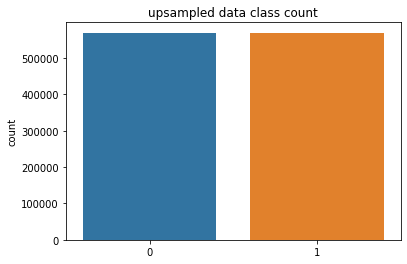

In [153]:
y=upsampled.isFraud.value_counts()
sns.barplot(y=y,x=[0,1])
plt.title('upsampled data class count')
plt.ylabel('count')
plt.show()

In [20]:
y = upsampled["isFraud"]
upsampled = upsampled.drop(["isFraud"],axis=1)


In [126]:
X_train, X_val, Y_train, Y_val = train_test_split(upsampled,y, 
                                                    test_size=0.15, 
                                                    random_state=42)

In [36]:
random_forest_up = RandomForestClassifier(n_jobs=-1)
random_forest_up.fit(X_train,Y_train)


RandomForestClassifier(n_jobs=-1)

In [37]:
print("Validation roc_auc_score",roc_auc_score(Y_val,random_forest_up.predict_proba(X_val)[:,1] ))

Validation roc_auc_score 1.0


In [38]:
feature =pd.DataFrame(random_forest_up.feature_importances_,columns=["Impotance"])
feature["features"]= random_forest_up.feature_names_in_
feature = feature.sort_values(by = "Impotance",ascending=False)

In [40]:
sample = pd.read_csv("sample_submission.csv")

In [41]:
sample = pd.read_csv("sample_submission.csv")
Y_pred = random_forest_up.predict_proba(test)[:,1]
sample["isFraud"] = Y_pred
sample.to_csv("Baseline_uprandomforest.csv",index = False)


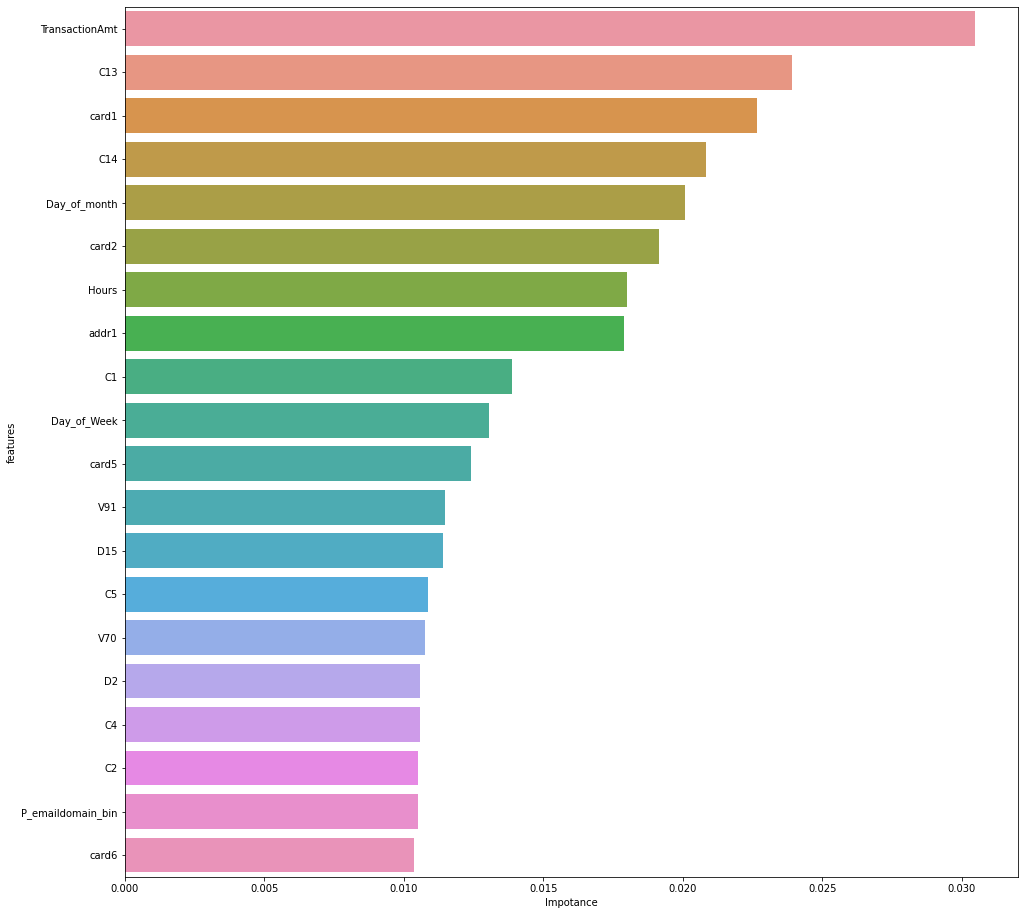

In [42]:
plt.figure(figsize=(16, 16))
sns.barplot(data=feature[:20], x='Impotance', y='features');


#### Kaggle Score : 0.898136 

## LightGBM 

In [46]:
import lightgbm
from lightgbm import LGBMClassifier
LGBMmodel = LGBMClassifier()
LGBMmodel.fit(X_train,Y_train)


In [48]:
print("Validation roc_auc_score",roc_auc_score(Y_val,LGBMmodel.predict_proba(X_val)[:,1] ))

Validation roc_auc_score 0.9751077178623226


In [49]:
sample = pd.read_csv("sample_submission.csv")
Y_pred = LGBMmodel.predict_proba(test)[:,1]
sample["isFraud"] = Y_pred
sample.to_csv("Baseline_LGBM.csv",index = False)

### Kaggle Score 0.916946 

### Adaboost 


In [50]:
from sklearn.ensemble import AdaBoostClassifier
modelADA = AdaBoostClassifier()
modelADA.fit(X_train,Y_train)

AdaBoostClassifier()

In [52]:
print("Validation roc_auc_score",roc_auc_score(Y_val,modelADA.predict_proba(X_val)[:,1] ))

Validation roc_auc_score 0.8729176866666171


In [53]:
sample = pd.read_csv("sample_submission.csv")
Y_pred = modelADA.predict_proba(test)[:,1]
sample["isFraud"] = Y_pred
sample.to_csv("Baseline_ADA.csv",index = False)

#### Adaboost Kaggle score : 0.888065

In [89]:
import lightgbm
from lightgbm import LGBMClassifier

In [82]:
from sklearn.model_selection import KFold, TimeSeriesSplit
from time import time


In [92]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47
         }

In [90]:
import lightgbm as lgb


In [91]:
folds = TimeSeriesSplit(n_splits=5)

aucs = list()

In [86]:
feature_importances = pd.DataFrame()
feature_importances['feature'] = X.columns

In [87]:
X = X_train
y = Y_train

## Xgboost 

In [127]:
clf = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=9,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    missing=-999,
    random_state=2019,
    tree_method='gpu_hist'  # THE MAGICAL PARAMETER
)

In [128]:
%time clf.fit(X_train, Y_train)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:14:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 6min 47s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9,
              enable_categorical=False, gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=9, min_child_weight=1, missing=-999,
              monotone_constraints='()', n_estimators=500, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=2019,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.9,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [129]:
print("Validation roc_auc_score",roc_auc_score(Y_val,clf.predict_proba(X_val)[:,1] ))

Validation roc_auc_score 0.9907683198549764


In [ ]:
sample = pd.read_csv("sample_submission.csv")
Y_pred = clf.predict_proba(test)[:,1]
sample["isFraud"] = Y_pred
sample.to_csv("Baseline_XGB.csv",index = False)

## Kaggle Score : 0.905887

In [137]:
feature_important = clf.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

<AxesSubplot:>

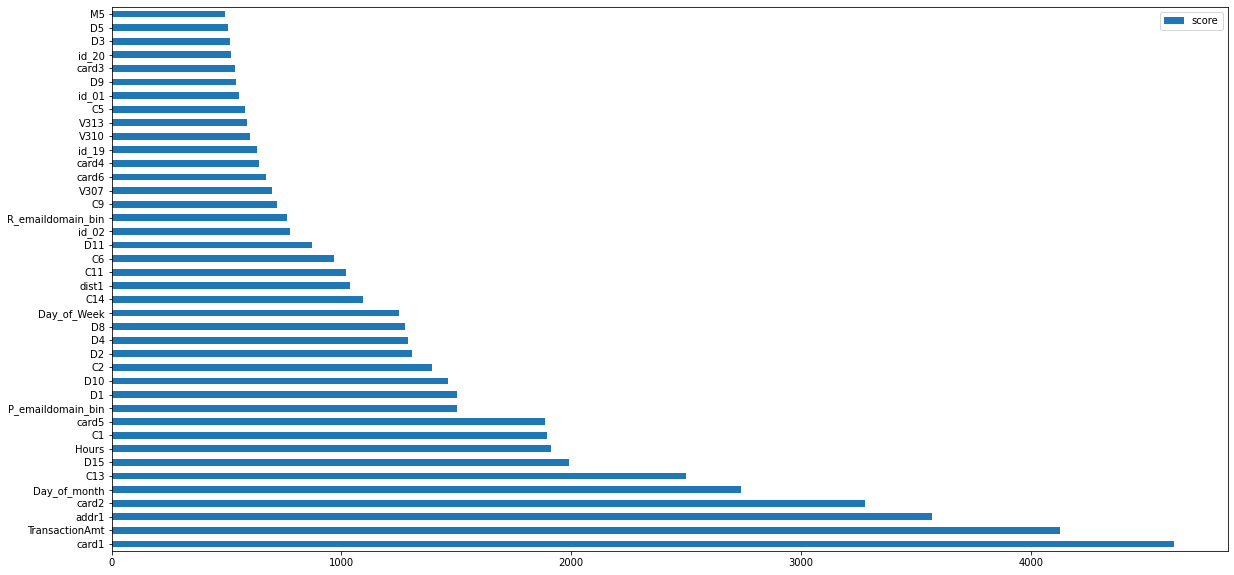

In [138]:


data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

#### Feature Engineering 

In [254]:
card1_trans_med = dict(X_new.groupby("card1")["TransactionAmt"].median())
card2_trans_med = dict(X.groupby("card2")["TransactionAmt"].median())
card3_trans_med = dict(X_new.groupby("card3")["TransactionAmt"].median())
card4_trans_med = dict(X_new.groupby("card4")["TransactionAmt"].median())
card5_trans_med = dict(X_new.groupby("card5")["TransactionAmt"].median())
card6_trans_med = dict(X_new.groupby("card6")["TransactionAmt"].median())

X_new["card1_trans_med"] = X_new["card1"].map(card_trans_med)
X_new["card2_trans_med"] = X_new["card2"].map(card_trans_med)
X_new["card3_trans_med"] = X_new["card3"].map(card_trans_med)
X_new["card4_trans_med"] = X_new["card4"].map(card_trans_med)
X_new["card5_trans_med"] = X_new["card5"].map(card_trans_med)
X_new["card6_trans_med"] = X_new["card6"].map(card_trans_med)

test["card1_trans_med"] = test["card1"].map(card_trans_med)
test["card2_trans_med"] = test["card2"].map(card2_trans_med)
test["card3_trans_med"] = test["card3"].map(card2_trans_med)
test["card4_trans_med"] = test["card4"].map(card2_trans_med)
test["card5_trans_med"] = test["card5"].map(card2_trans_med)
test["card6_trans_med"] = test["card6"].map(card2_trans_med)

X_new["addr1_card1"] = X_new[["card1","addr1"]].apply(lambda x: str(x["card1"]) +"_"+ str(x["addr1"]),axis=1)
X_new["addr1_card2"] = X_new[["card2","addr1"]].apply(lambda x: str(x["card2"]) +"_"+ str(x["addr1"]),axis=1)
X_new["addr1_card3"] = X_new[["card3","addr1"]].apply(lambda x: str(x["card3"]) +"_"+ str(x["addr1"]),axis=1)
X_new["addr1_card4"] = X_new[["card4","addr1"]].apply(lambda x: str(x["card4"]) +"_"+ str(x["addr1"]),axis=1)
X_new["addr1_card5"] = X_new[["card5","addr1"]].apply(lambda x: str(x["card5"]) +"_"+ str(x["addr1"]),axis=1)
X_new["addr1_card6"] = X_new[["card6","addr1"]].apply(lambda x: str(x["card6"]) +"_"+ str(x["addr1"]),axis=1)


In [258]:
test["addr1_card1"] = test[["card1","addr1"]].apply(lambda x: str(x["card1"]) +"_"+ str(x["addr1"]),axis=1)
test["addr1_card2"] = test[["card2","addr1"]].apply(lambda x: str(x["card2"]) +"_"+ str(x["addr1"]),axis=1)
test["addr1_card3"] = test[["card3","addr1"]].apply(lambda x: str(x["card3"]) +"_"+ str(x["addr1"]),axis=1)
test["addr1_card4"] = test[["card4","addr1"]].apply(lambda x: str(x["card4"]) +"_"+ str(x["addr1"]),axis=1)
test["addr1_card5"] = test[["card5","addr1"]].apply(lambda x: str(x["card5"]) +"_"+ str(x["addr1"]),axis=1)
test["addr1_card6"] = test[["card6","addr1"]].apply(lambda x: str(x["card6"]) +"_"+ str(x["addr1"]),axis=1)

In [259]:
for i in C:
    X_new["freq_"+i] = X_new[i].map(X_new.groupby(i).size()/len(X_new))
    test["freq_"+i] = test[i].map(test.groupby(i).size()/len(test))

### C vars cluster 

In [286]:
X_train, X_val, Y_train, Y_val = train_test_split(X_new,y, 
                                                    test_size=0.15, 
                                                    random_state=42)

In [326]:
import lightgbm
from lightgbm import LGBMClassifier
LGBMmodel = LGBMClassifier()
LGBMmodel.fit(X_train[cols],Y_train)

LGBMClassifier()

In [283]:
for f in tqdm(["addr1_card1", "addr1_card2", "addr1_card5", "addr1_card6", "addr1_card3", "addr1_card4"]):
    lbl = LabelEncoder()
    lbl.fit(list(X_new[f].values) + list(test[f].values))
    X_new[f] = lbl.transform(list(X_new[f].values))
    test[f] = lbl.transform(list(test[f].values))
    
       

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:13<00:00,  2.29s/it]


In [328]:
print("Validation roc_auc_score",roc_auc_score(Y_val,LGBMmodel.predict_proba(X_val[cols])[:,1] ))

Validation roc_auc_score 0.9453580228163271


In [291]:
y_pred = LGBMmodel.predict_proba(test)[:,1]

In [293]:
sub = pd.read_csv("Sub1.csv")

In [295]:
sub["isFraud"] = y_pred

In [298]:
sub.to_csv("FE.csv",index=False)

In [315]:
add_fe = ["card_trans_med","addr1_card2","addr1_card1","addr1_card6","card2_trans_med","addr1_card3","addr1_card4","addr1_card5","card5_trans_med","card3_trans_med"]

In [320]:
cols = list(upsampled.columns)

In [321]:
cols.extend(add_fe)

In [324]:
cols.remove("isFraud")

In [ ]:
,
Y_pred = LGBMmodel.predict_proba(test)[:,1]
sample["isFraud"] = Y_pred
sample.to_csv("Baseline_LGBM.csv",index = False)

In [314]:
feimp[:40]

,Feature,Value
437,card_trans_med,131
24,C13,95
0,TransactionAmt,89
440,addr1_card2,87
439,addr1_card1,86
2,card1,78
40,D15,63
457,addr1_card6,62
438,card2_trans_med,62
458,addr1_card3,62


In [309]:
feimp=pd.DataFrame({'Feature':LGBMmodel.feature_name_,'Value':LGBMmodel.feature_importances_}).sort_values(by="Value",ascending=False)
